In [1]:
from PyAWD.AcousticWaveDataset import *
import numpy as np
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from time import time
import torch
from torchinfo import summary

sns.set_theme()

In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    def __len__(self):
        return len(self.X)

In [3]:
train = torch.load("../../../local/datasets/AWD/train.pt")
X = [torch.Tensor(np.array([train.interrogate(i, inter) for inter in train.interrogators])) for i in range(train.size)]
Y = [torch.Tensor([train[i][0][0]/(train.nx/2)]) for i in range(train.size)]

In [4]:
print(X[0].shape)

torch.Size([4, 1000])


In [5]:
test = torch.load("../../../local/datasets/AWD/test.pt")
X_test = [torch.Tensor(np.array([test.interrogate(i, inter) for inter in test.interrogators])) for i in range(test.size)]
Y_test = [torch.Tensor([test[i][0][0]/(test.nx/2)]) for i in range(test.size)]

In [6]:
train = CustomDataset(X, Y)
train_loader = torch.utils.data.DataLoader(train, batch_size=10)

test = CustomDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test, batch_size=10)

In [32]:
def train_loop(loader, model, loss_fn, optimizer, scheduler):
    model.train()
    for x, y in loader:
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()

def test_loop(X, Y, model):
    model.eval()
    loss = 0
    for i in range(len(X)):
        pred = model(X[i])
        loss += loss_fn(pred, Y[i]).item()
    return loss/len(X)      

In [53]:
class FFN(torch.nn.Module):
    def __init__(self):
        super(FFN, self).__init__()

        self.linear1 = torch.nn.Linear(X[0].shape[-1], 250)
        self.activation = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(250, 50)
        self.unflatten = torch.nn.Unflatten(-2, (1, X[0].shape[0]))
        self.flatten = torch.nn.Flatten()
        self.linear3 = torch.nn.Linear(X[0].shape[0]*50, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.unflatten(x)
        x = self.flatten(x)
        x = self.linear3(x)
        x = self.flatten(x)
        x = self.activation(x)
        return x

model = FFN()
learning_rate = 1e-4
epochs = 1500
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.75)
losses = []

In [54]:
for e in tqdm(range(epochs)):
    train_loop(train_loader, model, loss_fn, optimizer, scheduler)
    losses.append(test_loop(X_test, Y_test, model))

  0%|          | 0/1500 [00:00<?, ?it/s]

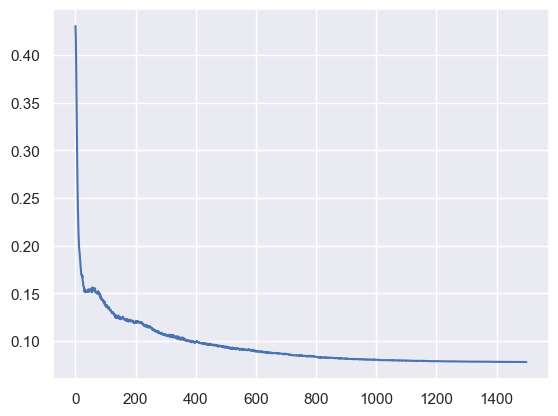

In [58]:
plt.plot(losses)
plt.savefig("../Results/FFN2_learning.png", dpi=250)

MAE: 0.07783980960084591


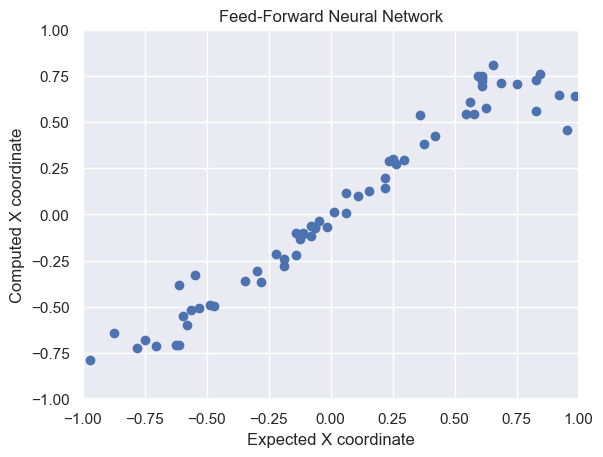

In [57]:
y_test= np.array([i.item() for i in Y_test])
y_hat = np.array([model.forward(i).detach().item() for i in X_test])
nn_mae = np.mean(np.abs(y_test-y_hat))
print("MAE:", nn_mae)
plt.scatter(y_test, y_hat)
plt.xlabel("Expected X coordinate")
plt.ylabel("Computed X coordinate")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Feed-Forward Neural Network")
plt.savefig("../Results/FFN2.png", dpi=250)